# Recommendation engine on MovieLens dataset

In this project we will build  recommendation engines for movies, based on MovieLens dataset. We will build two types of models:
   - Collaborative Filtering
   - Deep learnig model with use of embeddings
    
Our goal is building a model which correctly recommends movies for user, based on his taste. Information about user taste is passed by his movie ratings.  

## MovieLens dataset

We will be using the MovieLens dataset, it has been collected by the GroupLens Research Project at the University of Minnesota. MovieLens 1M dataset can be downloaded from here: https://grouplens.org/datasets/movielens/1m/, dataset contains:
   - 1 million ratings (1-5) from 6040 users and 3883 movies
   - each user has rated at least 20 movies
   - simple information abour user: gender, age, zip-code
   - genre informations 

Lets load data, and explore content of dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, Dot, Reshape, Dense, Flatten, Dropout, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, MinMaxScaler

from math import sqrt,log
from IPython.display import SVG

import warnings
warnings.simplefilter(action='ignore')


Using TensorFlow backend.


In [2]:
#Reading users file:
user_cols = ['user_id', 'sex', 'age', 'occupation', 'zip_code']
users = pd.read_csv('ml-1m/users.dat', sep="::", names=user_cols, encoding='latin-1')
print(users.shape)
users.head()

(6040, 5)


,user_id,sex,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


So we have 6040 users, and we have four personal informations about them: sex, age, occupation and zip_code

In [3]:
#Reading ratings file
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=rating_cols, encoding='latin-1')
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So we have just over 1 million ratings

In [4]:
#Reading movie file
movie_cols = ['movie_id', 'movie title','genres']
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=movie_cols, encoding='latin-1')
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,movie title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


So we have 3883 movies with specified genres seperated by '|'

## Collaborative Filtering

 First, we must construct our user-item matrix.

In [13]:
n_users = ratings.user_id.max()
n_movies = ratings.movie_id.max()

data_matrix = np.zeros((n_users, n_movies))

for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
data_matrix

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [19]:
user_similarity = 1 - pairwise_distances(data_matrix, metric='cosine')
movie_similarity = 1 - pairwise_distances(data_matrix.T, metric='cosine')

In [20]:
print(user_similarity)

[[1.         0.09638153 0.12060981 ... 0.         0.17460369 0.13359025]
 [0.09638153 1.         0.1514786  ... 0.06611767 0.0664575  0.21827563]
 [0.12060981 0.1514786  1.         ... 0.12023352 0.09467506 0.13314404]
 ...
 [0.         0.06611767 0.12023352 ... 1.         0.16171426 0.09930008]
 [0.17460369 0.0664575  0.09467506 ... 0.16171426 1.         0.22833237]
 [0.13359025 0.21827563 0.13314404 ... 0.09930008 0.22833237 1.        ]]


In [21]:
print(movie_similarity)

[[1.         0.39034871 0.26794263 ... 0.09347942 0.04282933 0.18269056]
 [0.39034871 1.         0.24094645 ... 0.08701306 0.02606255 0.12218461]
 [0.26794263 0.24094645 1.         ... 0.0622576  0.01007255 0.097786  ]
 ...
 [0.09347942 0.08701306 0.0622576  ... 1.         0.20280851 0.2346385 ]
 [0.04282933 0.02606255 0.01007255 ... 0.20280851 1.         0.19297221]
 [0.18269056 0.12218461 0.097786   ... 0.2346385  0.19297221 1.        ]]


Wth our similiarity matrices we can now predict ratings. 

In [22]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Finally, we will make predictions based on user similarity and item similarity. We we evaluate our model by calculating mean squared error.

In [25]:
user_prediction = predict(data_matrix, user_similarity, type = 'user')
movie_prediction = predict(data_matrix, movie_similarity, type = 'item')

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print(get_mse( user_prediction, data_matrix))
print(get_mse( movie_prediction, data_matrix))

8.51596752985705
9.982204807414094


## Deep Learning model

Previous model was not using gradient descent, so there was no training. Now we will try to take advantage of using gradient descent in building recomendation system with Keras.
First we will build neural network with two Embedding layers for users and movies. This layers will train Embedding matrices which will represent features of each user and movie. 

Following constants will define our Enbeddings matrices shapes, eventually this shapes should be:
n_movies X n_factors_movie
n_users X n_factor_users

So for each movie there will n_factors_movie features to describe andsimiliary for users there will n_factors_user features to descibe each user

In [30]:
n_factors_user = 5
n_factors_movie = 10

No we will split dataset into training set and test set. Additionally sklearn will shuffle data for us, which is desired because data ratng dataset is in asceding order.

In [118]:
train, test = train_test_split(ratings, test_size=0.2)
print(train.shape)
train.head()

(800167, 23)


,user_id,movie_id,rating,timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
688604,4118,3359,4,965805008,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.740741
388913,2279,2852,4,974560866,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.802469
765995,4561,588,5,970177065,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0.901235
277031,1675,1544,4,974711640,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.962963
118020,763,3107,4,975450466,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.888889


In [33]:
print(test.shape)
test.head()

(200042, 4)


,user_id,movie_id,rating,timestamp
586199,3578,1395,3,966711277
852582,5113,249,1,971968698
970670,5848,1017,4,957783392
214144,1300,2722,4,974789015
213826,1299,2085,4,974788781


User embedding layer, flatten and with dropout

In [34]:
user_input = Input(shape=[1],name='User')
user_embedding = Embedding(n_users + 1, n_factors_user,name='User-Embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
user_vec = Dropout(0.2)(user_vec)

Movie embedding layer, flatten and with dropout

In [14]:
movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(0.2)(movie_vec)

Concatenation of user and movie layes

In [15]:
concat = Concatenate()([movie_vec, user_vec])
concat_dropout = Dropout(0.4,name='Dropout-1')(concat)

Additional dense layer, used to extract more complex feature

In [16]:
dense_1 = Dense(100,name='FullyConnected-1')(concat_dropout)
dense_2 = Dense(50,name='FullyConnected-2')(dense_1)
dense_3 = Dense(20,name='FullyConnected-3')(dense_2)
dropout = Dropout(0.4,name='Dropout-2')(dense_3)

result = Dense(1, activation='relu',name='Activation')(dropout)

Initialize and compile model

In [13]:
adam = Adam(lr=0.001)
model = Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        39530       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         30205       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

Lets visualize our model

In [25]:
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

NameError: name 'model' is not defined

### Training and evaluation

Now we are ready to train our model.

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='auto')
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=5, 
                    validation_data = ([test.user_id, test.movie_id],  test.rating),
                    callbacks=[early_stopping],                   
                    verbose=1)

Train on 800167 samples, validate on 200042 samples
Epoch 1/5
800167/800167 [==============================] - 59s 74us/step - loss: 0.8169 - val_loss: 0.7359
Epoch 2/5
800167/800167 [==============================] - 68s 86us/step - loss: 0.7565 - val_loss: 0.7277
Epoch 3/5
800167/800167 [==============================] - 79s 99us/step - loss: 0.7513 - val_loss: 0.7221
Epoch 4/5
800167/800167 [==============================] - 80s 100us/step - loss: 0.7485 - val_loss: 0.7273


Because of Early Stopping technique, training session stoppped just after 4 epoch. to evaluate model we will use 'Mean Absolute Error'

In [17]:
y_pred = model.predict([test.user_id, test.movie_id])
print(mean_absolute_error(y_pred, test.rating))

0.727255811667066


Not bad, MSE for our model is 0.727, let see if we can achieve more

### Extended model

Now we will try to make our model even better, to do this we will:
- extend model input. So far we have ignored informations about users and movies (movie genres, user age, user occupation etc.). We can try to add some of this information to our model. In worst case we should achieve similar performance.
- extend our Embedding matrices by extending n_factors_user and n_factors_movie, bigger matrices will have more detailed features of movies and users
    

First we will prepare new inputs for our model, lets start of movies data

In [35]:
movies.head()

,movie_id,movie title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


We will extract genres of movies and covert them to one hot encoding

In [19]:
mlb = MultiLabelBinarizer()
genres = pd.DataFrame(mlb.fit_transform(movies.genres.str.split('|')),columns=mlb.classes_)
genres['movie_id'] = movies['movie_id']
genres.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_id
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5


We will cover year of the movie and normalize it

In [115]:
year = pd.DataFrame()
year['movie_id'] = movies['movie_id']
year['year'] = movies['movie title'].str[-5:-1].astype(float)
year.head()

,movie_id,year
0,1,1995.0
1,2,1995.0
2,3,1995.0
3,4,1995.0
4,5,1995.0


(array([  31.,   47.,   89.,   99.,  142.,  151.,  182.,  274.,  566.,
        2302.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

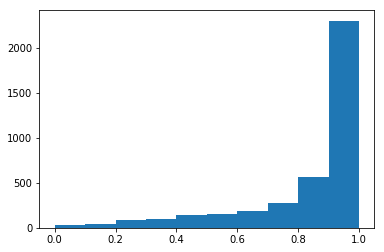

In [116]:
year['year'] = (year['year'] - year['year'].min())/(year['year'].max() - year['year'].min())
plt.hist(year['year'])

Now we have to merge thess dataFrames to 'ratings' dataset, we will merge on key = 'movie_id'

In [117]:
ratings = pd.merge(ratings, genres, how='left', on='movie_id')
ratings = pd.merge(ratings, year, how='left', on='movie_id')
ratings.head(10)

,user_id,movie_id,rating,timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,1193,5,978300760,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.691358
1,1,661,3,978302109,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0.950617
2,1,914,3,978301968,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0.555556
3,1,3408,4,978300275,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
4,1,2355,5,978824291,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0.975309
5,1,1197,3,978302268,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0.839506
6,1,1287,5,978302039,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.493827
7,1,2804,5,978300719,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.790123
8,1,594,4,978302268,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0.222222
9,1,919,4,978301368,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.246914


We ahve to split our data into training set and test set, and additionally we have to define which columns we will use in our new layer

In [120]:
extra_cols = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year']

train, test = train_test_split(ratings, test_size=0.2)
print(train.shape)
train.head()

(800167, 23)


,user_id,movie_id,rating,timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
552156,3401,3269,2,967431628,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0.901235
150187,967,3499,5,975115611,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.876543
154371,996,3114,4,975053093,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0.987654
897003,5424,50,5,981331884,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0.938272
393558,2316,1721,4,974558173,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.962963


Now we will define extended embedding layers, notice that we have changed number of factors for user from 5 to 10 and for movie from 10 to 15 

In [129]:
n_factors_user = 10
n_factors_movie = 15


movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(0.2)(movie_vec)

user_input = Input(shape=[1],name='User')
user_embedding = Embedding(n_users + 1, n_factors_user,name='User-Embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
user_vec = Dropout(0.2)(user_vec)

Now we will define extra layer for genres and year of the movie, and we will concatenate it.

In [130]:
extra_input = Input(shape=[len(extra_cols)], name='Extras')

concat = Concatenate()([extra_input, movie_vec, user_vec])
concat_dropout = Dropout(0.2,name='Dropout-1')(concat)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 15)        59295       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        60410       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

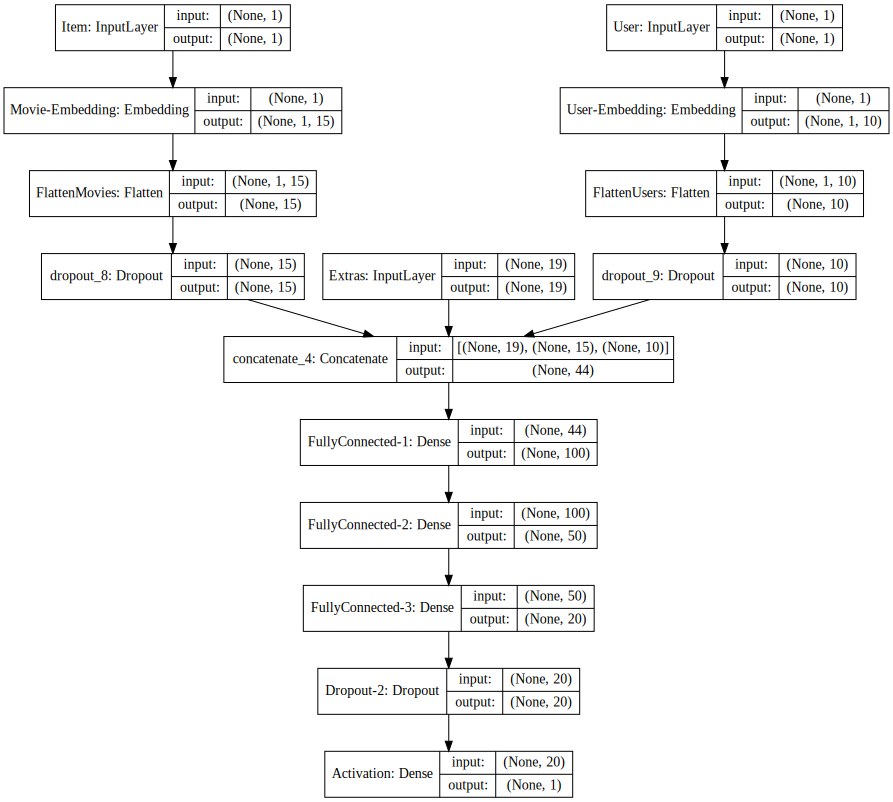

In [131]:
dense_1 = Dense(100,name='FullyConnected-1')(concat)
dense_2 = Dense(50,name='FullyConnected-2')(dense_1)
dense_3 = Dense(20,name='FullyConnected-3')(dense_2)
dropout = Dropout(0.2,name='Dropout-2')(dense_3)

result = Dense(1, activation='relu',name='Activation')(dropout)
adam = Adam(lr=0.001)

model = Model([user_input, movie_input, extra_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')
model.summary()

SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

We are ready to train our model

In [132]:
# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='auto')
history = model.fit([train.user_id, train.movie_id, train[extra_cols]], train.rating, epochs=5, 
                    validation_data = ([test.user_id, test.movie_id, test[extra_cols]],  test.rating),
                    callbacks=[early_stopping],                   
                    verbose=1)

Train on 800167 samples, validate on 200042 samples
Epoch 1/5
800167/800167 [==============================] - 84s 104us/step - loss: 0.7788 - val_loss: 0.7232
Epoch 2/5
800167/800167 [==============================] - 77s 96us/step - loss: 0.7291 - val_loss: 0.7181
Epoch 3/5
800167/800167 [==============================] - 75s 94us/step - loss: 0.7237 - val_loss: 0.7202


## Conclusion

Now it's clear that deep learning model is much more accurate that simple collaborative filtering. What can be done is comparision with other methods like: Popularity Model, Matrix facotrization, Apriori, Content-Based.

Our deep learning model is a hibrid of content-based and collaborative filtering and that is common trend in building reccomendation systems. It works well but there is so much left to tune, we could work on architecture, hypertuning and we could work on regularization because our model is overfitting very quickly.
